# scad

> OpenSCAD interface

In [ ]:
#| default_exp scad.__init__

In [ ]:
#| export
#import solid2
from solid2.core.object_base.object_base_impl import RenderMixin
from solid2 import *
import subprocess

from PIL import Image
import io
from fastcore.all import *

import matplotlib.pyplot as plt
import numpy
from stl import mesh
from mpl_toolkits import mplot3d
from matplotlib import pyplot

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
colorscheme = "Tomorrow Night" #"Cornfield"
colorschemes = [
    "Cornfield", "Metallic", "Sunset", "Starnight",
    "BeforeDawn", "Nature", "DeepOcean", "Solarized",
    "Tomorrow", "Tomorrow Night", "Monotone"
]

In [ ]:
a = (10,20,30)
','.join(map(str,a))

'10,20,30'

In [ ]:
a = []
if a:
    print("yes")

In [ ]:
#| export
def export_to(model, export_format, w=600, h=300, colorscheme=None,
              translate=None, rot=None, dist=None,
              eye=None, center=None, viewall=True):

    if (translate or rot or dist) and (eye or center):
        raise Exception("Only triple transalte,rot,dist or tuple eye,center can be specified at a time")

    camera = []

    if translate or rot or dist:
        translate = translate or (10,-10,10)
        rot = rot or (0,0,0)
        dist = dist or 10

    if eye or center:
        eye = eye or (10,-10,10)
        center = center or (0,0,0)

    if translate:
        camera = ','.join(map(str,translate + rot + (dist,)))
    if eye:
        camera = ','.join(map(str,eye + center))

    if camera:
        camera = ['--camera', camera]
    
    colorscheme = colorscheme or globals()['colorscheme']
    
    result = subprocess.run(
        ['openscad', '--colorscheme', colorscheme, '--imgsize', f'{w},{h}',
         '--export-format', export_format,
         #'--preview', 'throwntogether',
         '--view', 'axes,crosshairs,scales',
         #'--view', 'scales',
         '--projection', 'ortho',
         *camera,
         *(['--viewall'] if viewall else []),
         '-o', '-', '-'],
        input=bytes(str(model), 'utf-8'),
        capture_output=True,
        check=True
    )
    return result.stdout

In [ ]:
#| export
@delegates(export_to)
def view(model, w=600, h=300, colorscheme=None, **kwargs):
    "Convert model to image"
    # If we render at slightly higher resolution, the result looks smoother
    s = 1.75

    data = export_to(model, "png", w=int(s*w), h=int(s*h), colorscheme=colorscheme, **kwargs)

    return Image.open(io.BytesIO(data)).resize((w,h), resample=Image.LANCZOS)

Lets add simple and fast automatic previews for all models:

In [ ]:
#| export
@patch
def _repr_png_(self: RenderMixin):
    return view(self)._repr_png_()

del RenderMixin._ipython_display_
RenderMixin.__str__ = RenderMixin.__repr__
del RenderMixin.__repr__

We also delete `__repr__` so that text representations of models are not saved as part of notebooks.
These representations can get quite lengthy especially if we programatically generate models with python
as opposed to using OpenSCAD model and import functions.

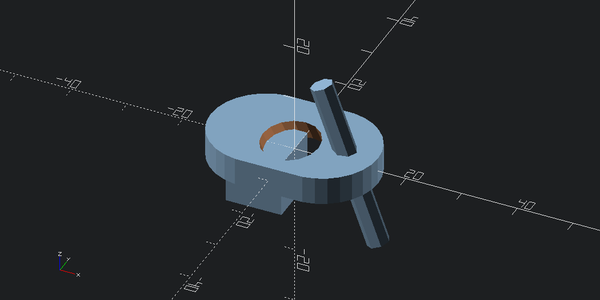

In [ ]:
d = ((cylinder(5,r=10,center=True).right(5) + cylinder(5,r=10,center=True).left(5)).hull()
     - cylinder(40,r=5, center=True).rotate([30,0,0])
     + cylinder(30,r=2,center=True).rotate([0,-20,0]).translate([10,0,0])
     + cube([10,10,10],center=True).translate([-5,0,-5]))
d

Viewing from different directions:

In [ ]:
#| export
@delegates(view)
def view_top(d, **kwargs): return view(d, eye=(0,0,1), **kwargs)
@delegates(view)
def view_bottom(d, **kwargs): return view(d, translate=(0,0,-1), rot=(180,0,0),dist=1, **kwargs)
# the one below flips x for some reason
#def view_bottom(d, **kwargs): return view(d, eye=(0,0,-1), **kwargs)
@delegates(view)
def view_right(d, **kwargs): return view(d, eye=(1,0,0), **kwargs)
@delegates(view)
def view_left(d, **kwargs): return view(d, eye=(-1,0,0), **kwargs)
@delegates(view)
def view_front(d, **kwargs): return view(d, eye=(0,-1,0), **kwargs)
@delegates(view)
def view_back(d, **kwargs): return view(d, eye=(0,1,0), **kwargs)

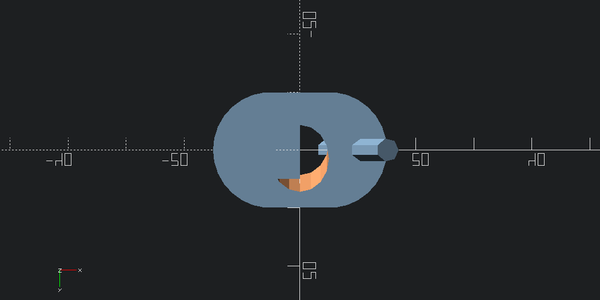

In [ ]:
view_bottom(d)

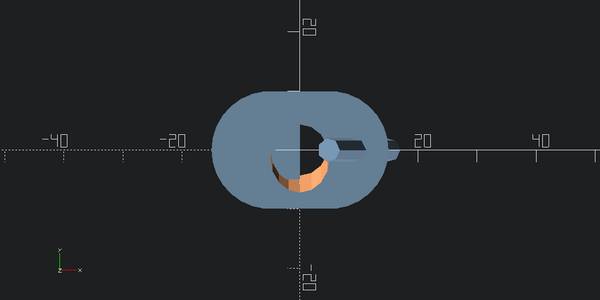

In [ ]:
view_top(d)

In [ ]:
12/3*2

8.0

In [ ]:
#| export
def view_all(d):
    fig, axs = plt.subplots(2,3, figsize=(12,8)) # 2,5
    axs = axs.flatten()

    dirs = [view_top, view_bottom, view_right, view_left, view_front, view_back]
    
    for ax, fun in zip(axs, dirs):
        title = fun.__name__.split("_")[1].capitalize()
        ax.imshow(fun(d, w=300, h=300))
        ax.axis("off")
        ax.set_title(title)

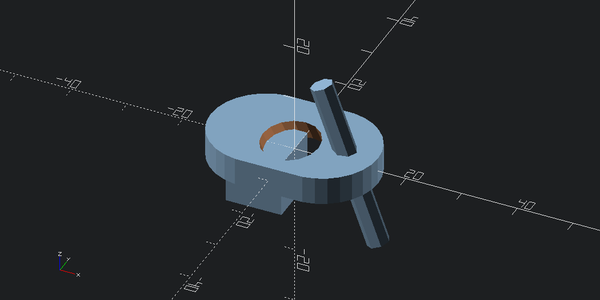

In [ ]:
d

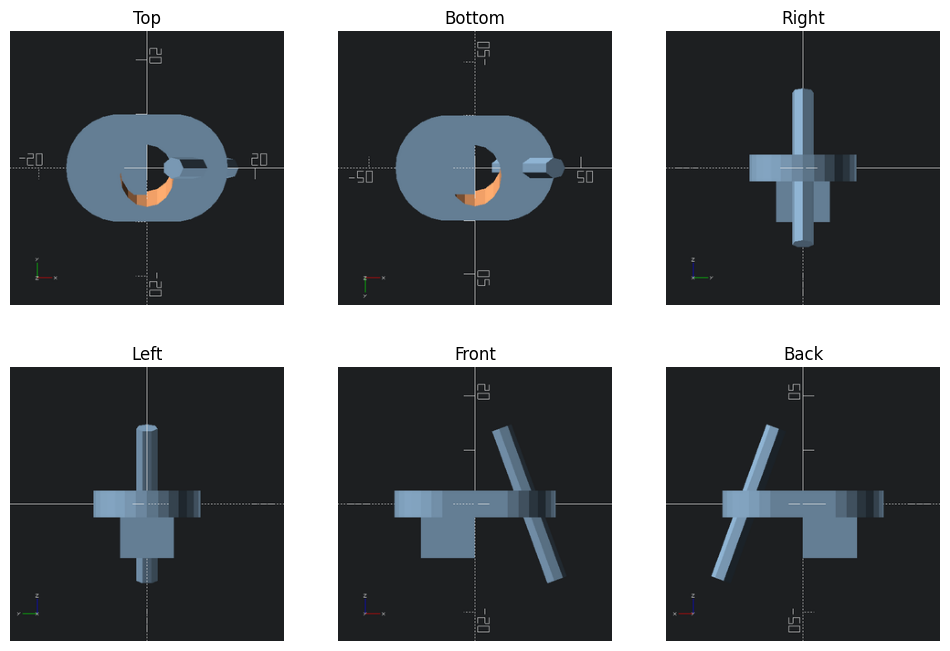

In [ ]:
view_all(d)

## Colorschemes

You can configure the colorscheme you like by setting `scad.colorscheme` to appropritate string:

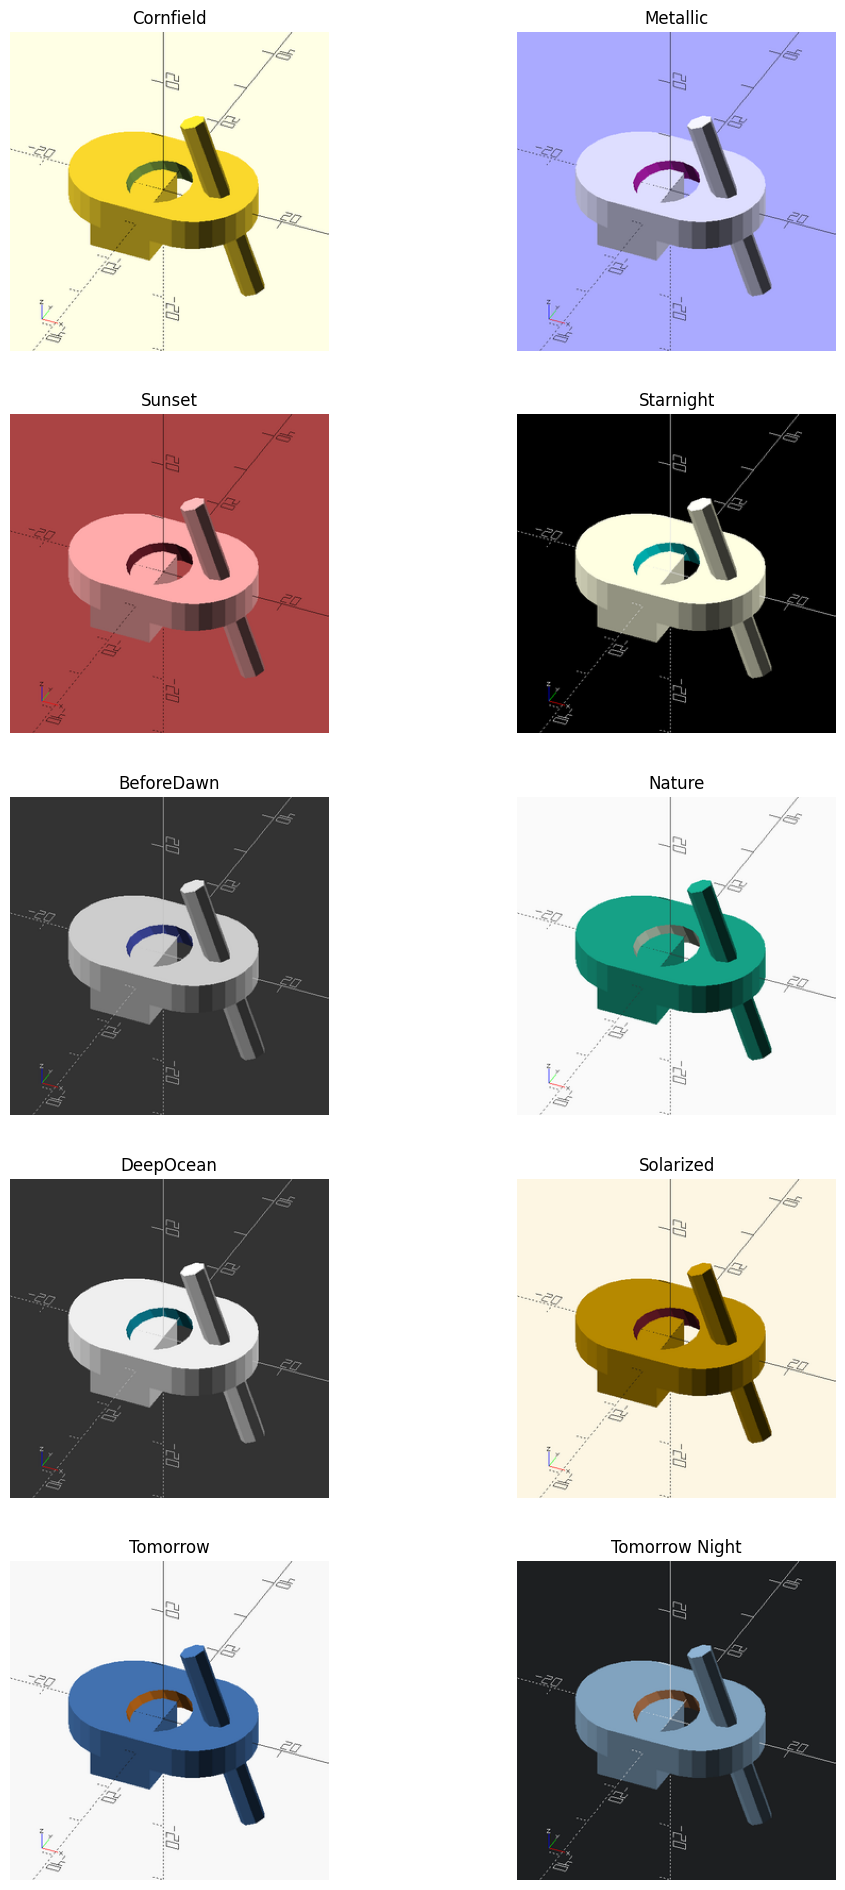

In [ ]:
fig, axs = plt.subplots(5,2, figsize=(12,24)) # 2,5
axs = axs.flatten()

for ax, cs in zip(axs, colorschemes):
    ax.imshow(view(d, 300, 300, cs))
    ax.axis("off")
    ax.set_title(cs)

## Exporting to STL

In [ ]:
#| export
def export_to_stl(model):
    stl = export_to(model, 'stl')
    stl = mesh.Mesh.from_file("", fh=io.BytesIO(stl))
    return stl

In [ ]:
stl = export_to_stl(d)

In [ ]:
volume, cog, inertia = stl.get_mass_properties()
print("Volume                                  = {0}".format(volume))
print("Position of the center of gravity (COG) = {0}".format(cog))
print("Inertia matrix at expressed at the COG  = {0}".format(inertia[0,:]))
print("                                          {0}".format(inertia[1,:]))
print("                                          {0}".format(inertia[2,:]))
print("Your mesh is closed: {0}".format(stl.is_closed(exact=True)))

Volume                                  = 3233.8717447916665
Position of the center of gravity (COG) = [-0.39244195  0.01129184 -1.48824022]
Inertia matrix at expressed at the COG  = [ 1.26691235e+05  9.59202307e+01 -1.40417640e+04]
                                          [ 9.59202307e+01  2.56363254e+05 -5.24176883e+02]
                                          [-14041.76401878   -524.17688261 279222.64519674]
Your mesh is closed: True


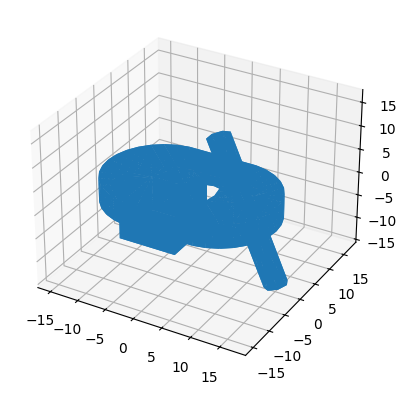

In [ ]:
figure = pyplot.figure()
axes = figure.add_subplot(projection='3d')

axes.add_collection3d(mplot3d.art3d.Poly3DCollection(stl.vectors))

scale = stl.points.flatten()
axes.auto_scale_xyz(scale, scale, scale)

pyplot.show()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()